In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys

In [2]:
sys.path.append('/home/local/WIN/msang2/mankun/dimerEnhanceProteinDNA/')
# modules for direct calculation
import analytics as ana
import analyzeEqui as num
# stochastic simulation (Gillespie)
from Simulations.odeSolver.doubleS import rxnNetwork, labels
from Simulations.odeSolver.main import main as numericSolver
# for generating parameters
from GenerateParameters import GenParameters

In [3]:
def plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.55,0.00], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=22,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
):
    labelfont = {'fontsize':labelFontSize*scale}
    tickfont = {'fontsize':tickFontSize*scale}
    legend = {'fontsize':lgdFontSize*scale, 'loc':lgdLoc, 'handlelength':lgdHandleL*scale, 
              'title':lgdTitle, 'title_fontsize':lgdTtlFontSize*scale,
             'framealpha':0.0}
    if fixSize:
        fig = plt.figure(figsize=(sizeX*scale,sizeY*scale))
        ax = fig.add_subplot(111)
    else:
        ax = plt.gca()
    plt.tick_params(length=tickL*scale, width=tickW*scale)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(spineLineW*scale)  # change width
    colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]
    linsStyles = ['-', '--']
    return ax, colors, linsStyles, legend, labelfont, tickfont, 0.6022 # C0, nm^-3 -> M

# old: a) residence time v.s. chiPN & gamma, dimer

In [15]:
GenParm = lambda KPP, nDenseKPN : GenParameters(
    numTargets=2, KPS=lambda KPN: 1e3*KPN, 
    NP0=[0.1], KPN=np.logspace(1, 3, 5+2*nDenseKPN)*2.0, 
    KPP=[KPP], 
    area3Dto1D=[1, 100], lengthScale=1,
)

parm_file = GenParm(np.exp(23), 20)
parm_num = GenParm(np.exp(23), 0)
parm_num_irr = GenParm(np.inf, 0)

In [16]:
def calc_resT_irr_2state(parm):
    gam = parm['gamma']
    konS = parm['kaPS']
    KPS = parm['KPS']
    CS = parm['CS0']
    konN = parm['kaPN']
    koffN = parm['kbPN']
    KPN = parm['KPN']
    CN = parm['CN0']
    C0 = 0.6022
    # combined parms
    chiN = KPN*CN
    chiS = KPS*CS
    aS_to_aN = konS*CS / (konN*CN)
    num_PS = 2*chiN + gam*chiN**2 + 2*chiS*(1+gam*chiN)**2
    num_PS2 = C0*KPS*chiS*(1+gam*chiN)**2
    return (num_PS+num_PS2)/2/chiN/(1+aS_to_aN) / koffN

def calc_resT_monomer_2state(parm):
    gam = parm['gamma']
    konS = parm['kaPS']
    KPS = parm['KPS']
    CS = parm['CS0']
    konN = parm['kaPN']
    koffN = parm['kbPN']
    KPN = parm['KPN']
    CN = parm['CN0']
    # combined parms
    chiN = KPN*CN
    chiS = KPS*CS
    aS_to_aN = konS*CS / (konN*CN)
    return (chiN+chiS*(1+gam*chiN))/chiN/(1+aS_to_aN) / koffN

def calc_tauA_irr(parm):
    gam = parm['gamma']
    koffN = parm['kbPN']
    KPN = parm['KPN']
    CN = parm['CN0']
    # combined parms
    chiN = KPN*CN
    return (1+gam*chiN/2)/koffN

resT_2s = np.zeros(parm_file.shape[0])
for iloc in range(parm_file.shape[0]):
    parm = parm_file.iloc[iloc]
    resT_2s[iloc] = ana.ana_resTime_balance(parm, numClusterS=2)
resT_2s_irr = calc_resT_irr_2state(parm_file)
resT_2s_m = calc_resT_monomer_2state(parm_file)
resT_A_irr = calc_tauA_irr(parm_file)

In [17]:
equi_num = numericSolver(parm_df=parm_num, labels=labels, model=rxnNetwork)
equi_num_irr = numericSolver(parm_df=parm_num_irr, labels=labels, model=rxnNetwork)

resT_num = np.zeros(parm_num.shape[0])
resT_num_irr = np.zeros(parm_num.shape[0])
for iloc in range(parm_num.shape[0]):
    parm = parm_num.iloc[iloc]
    equi = equi_num.iloc[iloc]
    equi_irr = equi_num_irr.iloc[iloc]
    resT_num[iloc] = num.calc_resT_modelC(parm, equi)
    resT_num_irr[iloc] = num.calc_resT_modelC(parm, equi_irr)
resT_num_m = calc_resT_monomer_2state(parm_num)

2024-11-04 10:30:41.465262
Number of cores used:  10/36
Finished parallel processing.
2024-11-04 10:30:47.073116
Number of cores used:  10/36
Finished parallel processing.


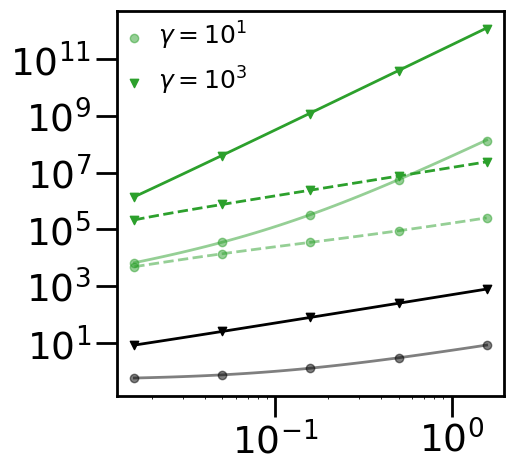

In [26]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.01,0.75], lgdFontSize=18, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=18,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
linsStyles = ['-', '--']
alphas = [0.5, 1]
markers = ['o','v']
gam_color = 'tab:green'
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
gamList = np.unique(parm_file['gamma'])
for i, gam in enumerate(gamList):
    selected = ((parm_file['gamma']==gam))
    selected_num = ((parm_num['gamma']==gam))
    ax.plot(
        (parm_file['KPN']*parm_file['CN0'])[selected],
        (resT_2s*parm_file['kbPS'])[selected],
        color=gam_color, lw=2, ls='--', alpha=alphas[i],
    )
    ax.plot(
        (parm_file['KPN']*parm_file['CN0'])[selected],
        (resT_2s_irr*parm_file['kbPS'])[selected],
        color=gam_color, lw=2, ls='-', alpha=alphas[i],
    )
    ax.plot(
        (parm_file['KPN']*parm_file['CN0'])[selected],
        (resT_2s_m*parm_file['kbPS'])[selected],
        color='black', lw=2, ls='-', alpha=alphas[i],
    )
    # numerical solution (true)
    ax.scatter(
        (parm_num['KPN']*parm_num['CN0'])[selected],
        (resT_num*parm_num['kbPS'])[selected_num],
        color=gam_color, alpha=alphas[i], marker=markers[i],
        label='$\\gamma=10^{%.0f}$'%np.log10(gam),
    )
    ax.scatter(
        (parm_num['KPN']*parm_num['CN0'])[selected],
        (resT_num_irr*parm_num['kbPS'])[selected_num],
        color=gam_color, alpha=alphas[i], marker=markers[i],
    )
    ax.scatter(
        (parm_num['KPN']*parm_num['CN0'])[selected],
        (resT_num_m*parm_num['kbPS'])[selected_num],
        color='black', alpha=alphas[i], marker=markers[i],
    )

ax.loglog()
plt.legend(**legend)
plt.xticks(**tickfont)
# plt.ylim([1e-2,2e2])
plt.yticks(**tickfont)
plt.show()

In [4]:
# Generate parameters
# Define the column headers
# units: nm & s
# conversion: 0.6022 nm^-3 = 1 M

def __staticParms(plotDenseData=False, denseKPN=True, denseKPP=True, denseCP0=False):
    
    kaPN = lambda K: 200
    kbPN = lambda K: kaPN(K)/K
    
    kaPS = lambda K: 1000
    kbPS = lambda K: kaPS(K)/K
    
    V0 = 2.1e4 # nm^3
    VtoL = 1000 # nm^2

    CN0 = 10/V0 # nm^-3
    CS0 = 2/V0
    C0 = 0.6022 # 0.6022 nm^-3 = 1 M 
    
    # whether more dense data points

    nDenseKPN = 0
    nDenseKPP = 0
    nDenseCP0 = 0
    if plotDenseData:
        if denseKPN: nDenseKPN = 43
        if denseKPP: nDenseKPP = 8
        if denseCP0: nDenseCP0 = 10
    
    return kaPN, kbPN, kaPS, kbPS, V0, VtoL, CN0, CS0, C0, nDenseKPN, nDenseKPP, nDenseCP0
    

def GenerateParameters_or_write(
    filename='', ifwrite=False, 
    plotDenseData=False, denseKPN=True, denseKPP=True, denseCP0=False
):
    headers = [
        "ID", "CN0", "CS0", "CP0", 
        "KPS", "KPN", "KPP", "gamma", 
        "kaPS", "kaPN", "kaPP", 
        "kbPS", "kbPN", "kbPP"
    ]

    # generate data
    data = []
    number = 0
    kaPN, kbPN, kaPS, kbPS, V0, VtoL, CN0, CS0, C0, nDenseKPN, nDenseKPP, nDenseCP0 = \
    __staticParms(plotDenseData, denseKPN, denseKPP, denseCP0)

    KPP = np.exp(23)/C0
    CP0 = 0.1/V0   
    kbPP = lambda K: 10 / (KPP*C0/1e1)**(4/9)
    kaPP = lambda K: K*kbPP(K)
    KPN = 2e3 / C0
    for CS0 in np.linspace(1,3)/V0:
        KPS = 1e3 * KPN
        for area3Dto1D in [1, 100]:
            entry = {
                'ID':number,
                "CN0":CN0,
                "CS0":CS0,
                "CP0":CP0,
                "KPN":np.round(KPN, 10),
                "kaPN":np.round(kaPN(KPN), 10),
                "kbPN":np.round(kbPN(KPN), 10),
                "KPS":np.round(KPS, 10),
                "kaPS":np.round(kaPS(KPS), 10),
                "kbPS":np.round(kbPS(KPS), 10),
                "KPP":np.round(KPP, 10),
                "kaPP":np.round(kaPP(KPP), 10),
                "kbPP":np.round(kbPP(KPP), 10),
                "gamma":VtoL/area3Dto1D
            }
            data.append(entry)
            number += 1

    if ifwrite:
        # Specify the output CSV file name
        output_file = filename
        # # Write the data to the CSV file
        import csv
        with open(output_file, mode="w", newline="") as file:
            writer = csv.DictWriter(file, fieldnames=headers)
            writer.writeheader()
            writer.writerows(data)
        print("CSV file generated successfully!")
    
    return pd.DataFrame(data, columns=headers)

parm_file = GenerateParameters_or_write(
    ifwrite=False, plotDenseData=True, 
    denseKPN=True, denseKPP=False, denseCP0=False,
)

In [12]:
def calc_resT_irr_2state(parm):
    gam = parm['gamma']
    konS = parm['kaPS']
    KPS = parm['KPS']
    CS = parm['CS0']
    konN = parm['kaPN']
    koffN = parm['kbPN']
    KPN = parm['KPN']
    CN = parm['CN0']
    C0 = 0.6022
    # combined parms
    chiN = KPN*CN
    chiS = KPS*CS
    aS_to_aN = konS*CS / (konN*CN)
    num_PS = 2*chiN + gam*chiN**2 + 2*chiS*(1+gam*chiN)**2
    num_PS2 = C0*KPS*chiS*(1+gam*chiN)**2
    return (num_PS+num_PS2)/2/chiN/(1+aS_to_aN) / koffN

resT_2s_irr = calc_resT_irr_2state(parm_file)
resT_num_m = calc_resT_monomer_2state(parm_file)
resT_2s = np.zeros(parm_file.shape[0])
dimerEnh = np.zeros(parm_file.shape[0])
for iloc in range(parm_file.shape[0]):
    parm = parm_file.iloc[iloc]
    resT_2s[iloc] = ana.ana_resTime_balance(parm, numClusterS=2)
    dimerEnh[iloc] = ana.ana_enh(parm, numClusterS=2)



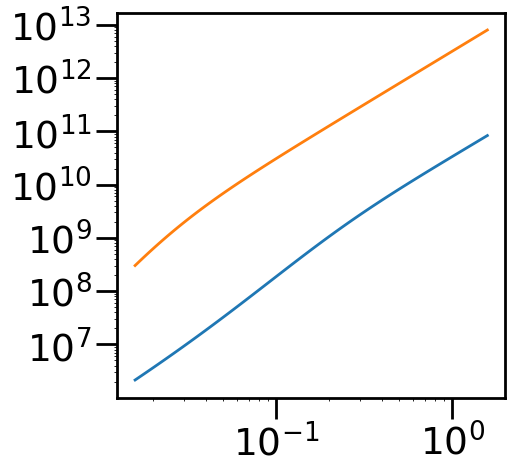

In [15]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
scale = 1.0
labelfont = {'fontsize':20*scale}
tickfont = {'fontsize':27*scale}
legend = {'fontsize':16*scale, 'loc':[0.01,0.6], 'handlelength':0.5*scale, 
#           'title':'$k_{on}^N$ ($M^{-1}s^{-1}$)', 'title_fontsize':16*scale,
         'framealpha':0.0}
fig = plt.figure(figsize=(5*scale,5*scale)); ax = fig.add_subplot(111)
plt.tick_params(length=15*scale, width=2*scale)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2*scale)  # change width
C0 = 0.6022 # nm^-3 -> M
colors = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
]
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# linsStyles = ['-', '--']
colors = ['tab:blue', 'tab:orange', 'tab:green']
gamList = np.unique(parm_file['gamma'])
for i, gam in enumerate(gamList):
    selected = ((parm_file['gamma']==gam))
    
    ax.plot(
        (parm_file['KPN']*parm_file['CN0'])[selected],
        (resT_2s*parm_file['kaPS'])[selected],
        label='$\\gamma=10^{%.0f}$'%np.log10(gam),
        color=colors[i], lw=2,
    )
    
# plt.axhline(C0/np.unique(parm_file['CS0']), color='gray')
ax.loglog()
# plt.legend(**legend)
plt.xticks(**tickfont)
# plt.ylim([1e-2,2e2])
plt.yticks(**tickfont)
plt.show()

# a) residence time v.s. KPP & CP0, strong KPN

In [4]:
def criticalRate_approx(parm):
    kbPS = parm['kbPS'].to_numpy()
    kbPN = parm['kbPN'].to_numpy()
    chiN = parm['KPN'].to_numpy()*parm['CN0'].to_numpy()
    chiS = parm['KPS'].to_numpy()*parm['CS0'].to_numpy()
    gamma = parm['gamma'].to_numpy()
    return gamma*(kbPS*chiS + kbPN*chiN)

In [25]:
GenParm = lambda nDenseKPP, kbP: GenParameters(
    numTargets=2, KPN=[20], KPS=lambda KPN: 20000, area3Dto1D=[10], 
    kaPN=1, kaPS=2, 
    NP0=[0.1], KPP=np.logspace(0,9,10+9*nDenseKPP), kbPP_fixed=kbP
)
parm_file = pd.concat((GenParm(10, 1), GenParm(10, 0.1), GenParm(10, 10)))
parm_num = pd.concat((GenParm(0, 1), GenParm(0, 0.1), GenParm(0, 10)))

In [26]:
parm_num['CP0'].unique()/0.6022, np.unique(criticalRate_approx(parm_num))

(array([7.90751372e-06]), array([0.06666667]))

In [27]:
def calc_resT_irr_2state(parm):
    gam = parm['gamma']
    konS = parm['kaPS']
    KPS = parm['KPS']
    CS = parm['CS0']
    konN = parm['kaPN']
    koffN = parm['kbPN']
    KPN = parm['KPN']
    CN = parm['CN0']
    C0 = 0.6022
    # combined parms
    chiN = KPN*CN
    chiS = KPS*CS
    aS_to_aN = konS*CS / (konN*CN)
    num_PS = 2*chiN + gam*chiN**2 + 2*chiS*(1+gam*chiN)**2
    num_PS2 = C0*KPS*chiS*(1+gam*chiN)**2
    return (num_PS+num_PS2)/2/chiN/(1+aS_to_aN) / koffN

def calc_resT_monomer_2state(parm):
    gam = parm['gamma']
    konS = parm['kaPS']
    KPS = parm['KPS']
    CS = parm['CS0']
    konN = parm['kaPN']
    koffN = parm['kbPN']
    KPN = parm['KPN']
    CN = parm['CN0']
    # combined parms
    chiN = KPN*CN
    chiS = KPS*CS
    aS_to_aN = konS*CS / (konN*CN)
    return (chiN+chiS*(1+gam*chiN))/chiN/(1+aS_to_aN) / koffN

def calc_tauA_irr(parm):
    gam = parm['gamma']
    koffN = parm['kbPN']
    KPN = parm['KPN']
    CN = parm['CN0']
    # combined parms
    chiN = KPN*CN
    return (1+gam*chiN/2)/koffN

resT_2s = np.zeros(parm_file.shape[0])
for iloc in range(parm_file.shape[0]):
    parm = parm_file.iloc[iloc]
    resT_2s[iloc] = ana.ana_resTime_balance(parm, numClusterS=2)
resT_2s_m = calc_resT_monomer_2state(parm_file)
resT_A_irr = calc_tauA_irr(parm_file)

In [28]:
equi_num = numericSolver(parm_df=parm_num, labels=labels, model=rxnNetwork)

resT_num = np.zeros(parm_num.shape[0])
for iloc in range(parm_num.shape[0]):
    parm = parm_num.iloc[iloc]
    equi = equi_num.iloc[iloc]
    resT_num[iloc] = num.calc_resT_modelC(parm, equi)
resT_num_m = calc_resT_monomer_2state(parm_num)

2024-11-14 15:36:41.892784
Number of cores used:  30/36
Finished parallel processing.


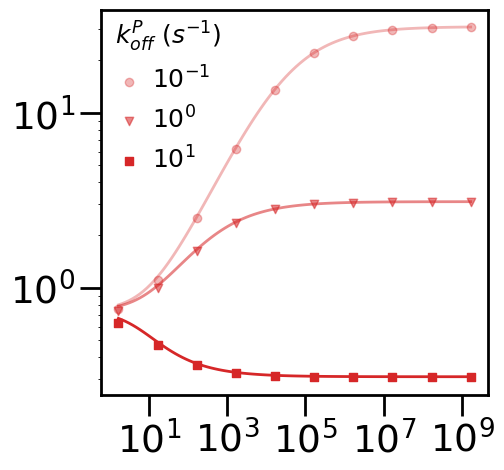

In [29]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.01,0.55], lgdFontSize=18, lgdHandleL=0.3, 
    lgdTitle='$k_{off}^P\ (s^{-1})$', lgdTtlFontSize=18,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
alphas = [3/9, 5/9, 1]
markers = ['o','v','s']
kbP_color = 'tab:red'
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
kbPList = np.unique(parm_file['kbPP'])
for i, kbP in enumerate(kbPList):
    selected = ((parm_file['kbPP']==kbP))
    selected_num = ((parm_num['kbPP']==kbP))
    ax.plot(
        (parm_file['KPP'])[selected],
        (resT_2s*parm_file['kbPS'])[selected],
        lw=2, color=kbP_color, alpha=alphas[i],
    )
    # numerical solution (true)
    ax.scatter(
        (parm_num['KPP'])[selected_num],
        (resT_num*parm_num['kbPS'])[selected_num],
        label='$10^{%.0f}$'%np.log10(kbP),
        marker=markers[i], color=kbP_color, alpha=alphas[i],
    )

ax.loglog()
plt.legend(**legend)
plt.xticks(**tickfont)
plt.yticks(**tickfont)
plt.show()

# b) occupancy v.s. KPP, KPN

In [22]:
GenParm = lambda nDenseKPP, areaList, kpnList: GenParameters(
    numTargets=2, KPN=kpnList, area3Dto1D=areaList, KPS=lambda KPN: 1e4,
    NP0=[2], KPP=np.logspace(0,9,10+9*nDenseKPP), 
)

parm_file = GenParm(10, [1,10,100], [20])
parm_num = GenParm(0, [1,10,100], [20])

In [23]:
parm_num['CP0'].unique()/0.6022*1e6

array([158.15027439])

In [24]:
pBound = np.zeros(parm_file.shape[0])
sOcc = np.zeros(parm_file.shape[0])
for iloc in range(parm_file.shape[0]):
    parm = parm_file.iloc[iloc]
    pBound[iloc] = ana.ana_bound_ratio(parm, numClusterS=2)
    sOcc[iloc] = ana.ana_occupancy(parm, numClusterS=2)

In [25]:
equi_num = numericSolver(parm_df=parm_num, labels=labels, model=rxnNetwork)

2024-11-14 15:01:04.336282
Number of cores used:  30/36
Finished parallel processing.


In [26]:
pBound_num = np.zeros(parm_num.shape[0])
sOcc_num = np.zeros(parm_num.shape[0])
for iloc in range(parm_num.shape[0]):
    parm = parm_num.iloc[iloc]
    equi = equi_num.iloc[iloc]
    pBound_num[iloc] = num.calc_BoundRatio_modelC(parm, equi)
    sOcc_num[iloc] = num.calc_occS_modelC(parm, equi)

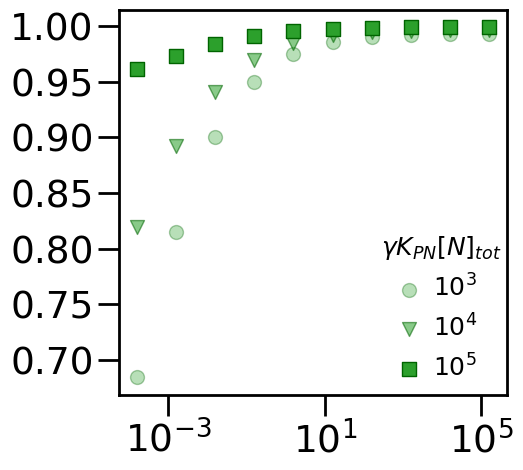

In [27]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.65,0.01], lgdFontSize=18, lgdHandleL=0.3, 
    lgdTitle='$\gamma K_{PN}[N]_{tot}$', lgdTtlFontSize=18,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
alphas = [3/9, 5/9, 1]
markers = ['o','v','s']
gam_color = 'tab:green'
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
linsStyles = ['-', '--']

gamList = np.unique(parm_file['gamma'])
for i, gam in enumerate(gamList):
    selected = ((parm_file['gamma']==gam))
    selected_num = ((parm_num['gamma']==gam))
    # numerical solution (true)
    ax.scatter(
        (parm_num['KPP']*parm_num['CP0'])[selected_num],
        (sOcc_num/(parm_num['CP0']/parm_num['CS0']))[selected_num],
        zorder=3, s=100, color = gam_color, edgecolor='darkgreen', 
        alpha=alphas[i], marker=markers[i],
        label='$10^{%.0f}$'%(np.log10(gam*np.unique(parm_num['KPN']))),
    )

ax.semilogx()
plt.legend(**legend)
plt.xticks([1e-3, 1e1, 1e5], **tickfont)
plt.yticks(**tickfont)
# plt.xticks([1e-6, 1e-3, 1e0, 1e3],['$10^{-6}$', '$10^{-3}$', '$10^{0}$', '$10^{3}$'],**tickfont)
# plt.yticks([0.65, 0.82, 1],['0.65', '0.82', '1.00'],**tickfont)
plt.show()

# c) protein bound ratio

In [37]:
GenParms = lambda KPNList, KPP: GenParameters(
    numTargets=2, KPN=KPNList, KPS=lambda KPN: 1e4, 
    NP0=[0.02], KPP=[KPP], area3Dto1D=[10, 1000],
)
KPP_rev = 3e2

In [38]:
parm_ana = GenParms(np.logspace(1, 3, 5+2*40)*2.0, KPP_rev)

parm_num_irr = GenParms(np.logspace(1, 3, 5+2*0)*2.0, np.inf)
parm_num_rev = GenParms(np.logspace(1, 3, 5+2*0)*2.0, KPP_rev)
parm_num_m = GenParms(np.logspace(1, 3, 5+2*0)*2.0, 0)

In [39]:
np.unique(parm_ana['CP0']*parm_ana['KPP']), np.unique(parm_ana['CP0']*1e6/0.6022)

(array([0.00047445]), array([1.58150274]))

In [40]:
def pBound_irr(parms):
    gam = parms['gamma']
    chiN = parms['KPN']*parms['CN0']
    chiS = parms['KPS']*parms['CS0']
    KPS = parms['KPS']
    C0 = 0.6022
    proBound = 2*chiN + gam*chiN**2 + (2*chiS + C0*KPS*chiS)*(1+gam*chiN)**2
    return proBound / (1 + proBound)

def pBound_m(parms):
    gam = parms['gamma']
    chiN = parms['KPN']*parms['CN0']
    chiS = parms['KPS']*parms['CS0']
    proBound = chiN + chiS*(1+gam*chiN)
    return proBound / (1 + proBound)

pBound_irr = pBound_irr(parm_ana)
pBound_m = pBound_m(parm_ana)
pBound_rev = np.zeros(parm_ana.shape[0])
for iloc in range(parm_ana.shape[0]):
    pBound_rev[iloc] = ana.ana_bound_ratio(parm_ana.iloc[iloc], numClusterS=2)

In [41]:
equi_m = numericSolver(parm_df=parm_num_m, labels=labels, model=rxnNetwork)
equi_irr = numericSolver(parm_df=parm_num_irr, labels=labels, model=rxnNetwork)
equi_rev = numericSolver(parm_df=parm_num_rev, labels=labels, model=rxnNetwork)

pBound_num_m = np.zeros(parm_num_m.shape[0])
pBound_num_irr = np.zeros(parm_num_m.shape[0])
pBound_num_rev = np.zeros(parm_num_m.shape[0])
for iloc in range(parm_num_m.shape[0]):
    pBound_num_m[iloc] = num.calc_BoundRatio_modelC(parm_num_m.iloc[iloc], equi_m.iloc[iloc])
    pBound_num_irr[iloc] = num.calc_BoundRatio_modelC(parm_num_irr.iloc[iloc], equi_irr.iloc[iloc])
    pBound_num_rev[iloc] = num.calc_BoundRatio_modelC(parm_num_rev.iloc[iloc], equi_rev.iloc[iloc])

2024-11-14 16:07:41.425733
Number of cores used:  10/36
Finished parallel processing.
2024-11-14 16:07:41.750216
Number of cores used:  10/36
Finished parallel processing.
2024-11-14 16:07:42.594188
Number of cores used:  10/36
Finished parallel processing.


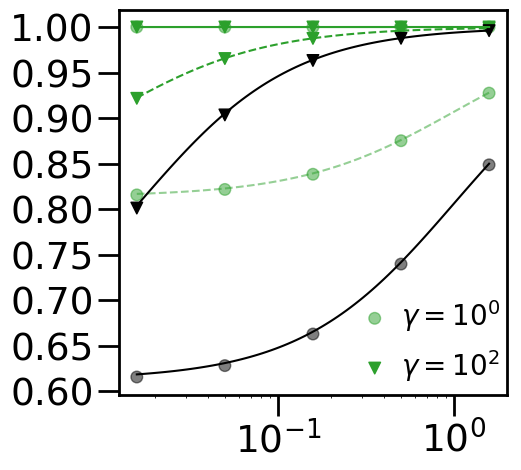

In [42]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, _, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.62,0.00], lgdFontSize=20, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=20,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
color_gamma = 'tab:green'
alphas = [0.5, 1]
markers = ['o','v']
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
gamList = np.unique(parm_ana['gamma'])
for j, gam in enumerate(gamList):
    selected = ((parm_ana['gamma']==gam))
    # analytics
    ax.plot(
        (parm_ana['KPN']*parm_ana['CN0'])[selected],
        pBound_irr[selected], ls='-',
        color = color_gamma, alpha=alphas[j],
    )
    ax.plot(
        (parm_ana['KPN']*parm_ana['CN0'])[selected],
        pBound_rev[selected], ls='--',
        color = color_gamma, alpha=alphas[j],
    )
    ax.plot(
        (parm_ana['KPN']*parm_ana['CN0'])[selected],
        pBound_m[selected],
        color='black',
    )
    # numerics
    selected_num = ((parm_num_irr['gamma']==gam))
    ax.scatter(
        (parm_num_irr['KPN']*parm_num_irr['CN0'])[selected_num],
        pBound_num_irr[selected_num], s=70,
        ls='', marker=markers[j],
        color=color_gamma, alpha=alphas[j],
        label='$\\gamma=10^{%.0f}$'%np.log10(gam),
    )
    ax.scatter(
        (parm_num_irr['KPN']*parm_num_irr['CN0'])[selected_num],
        pBound_num_rev[selected_num], s=70,
        ls='', marker=markers[j],
        color=color_gamma, alpha=alphas[j],
    )
    ax.scatter(
        (parm_num_m['KPN']*parm_num_m['CN0'])[selected_num],
        pBound_num_m[selected_num],  s=70,
        marker=markers[j], alpha=alphas[j],
        ls='', color='black',
    )
    
ax.semilogx()
# ax.set_aspect(aspect=1, adjustable='box')
plt.legend(**legend)
plt.xticks(**tickfont)
plt.yticks(**tickfont)
# plt.grid(axis='x')
plt.savefig('pBound_vs_chiN_gamma.png', transparent=True)
# plt.show()

# old: c) and d) protein bound ratio v.s. KPP & KPN

In [11]:
GenParm = lambda nDenseKPP, area3Dto1D, kpnList: GenParameters(
    numTargets=2, KPN=kpnList, area3Dto1D=[area3Dto1D], KPS=lambda KPN: 1e4,
    NP0=[2], KPP=np.logspace(0,9,10+9*nDenseKPP), kbPP_fixed=0.01,
)

parm_file = GenParm(10, 10, [20, 200, 2000])
parm_num = GenParm(0, 10, [20, 200, 2000])

In [12]:
pBound = np.zeros(parm_file.shape[0])
sOcc = np.zeros(parm_file.shape[0])
for iloc in range(parm_file.shape[0]):
    parm = parm_file.iloc[iloc]
    pBound[iloc] = ana.ana_bound_ratio(parm, numClusterS=2)
    sOcc[iloc] = ana.ana_occupancy(parm, numClusterS=2)

In [13]:
equi_num = numericSolver(parm_df=parm_num, labels=labels, model=rxnNetwork)

2024-11-14 14:53:25.966275
Number of cores used:  30/36
Finished parallel processing.


In [14]:
pBound_num = np.zeros(parm_num.shape[0])
sOcc_num = np.zeros(parm_num.shape[0])
for iloc in range(parm_num.shape[0]):
    parm = parm_num.iloc[iloc]
    equi = equi_num.iloc[iloc]
    pBound_num[iloc] = num.calc_BoundRatio_modelC(parm, equi)
    sOcc_num[iloc] = num.calc_occS_modelC(parm, equi)

NameError: name 'gam' is not defined

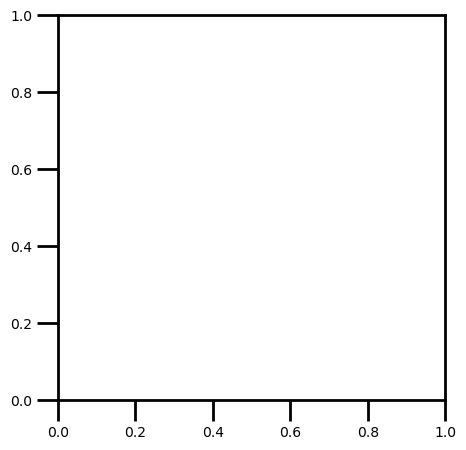

In [15]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.01,0.55], lgdFontSize=18, lgdHandleL=0.3, 
    lgdTitle='$k_{off}^P\ (s^{-1})$', lgdTtlFontSize=18,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
alphas = [3/9, 5/9, 1]
markers = ['o','v','s']
kbP_color = 'tab:red'
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
linsStyles = ['-', '--']

gamList = np.unique(parm_file['gamma'])
kpnList = np.unique(parm_file['KPN'])
for i, kpn in enumerate(kpnList):
    selected = ((parm_file['gamma']==gam)&(parm_file['KPN']==kpn))
    selected_num = ((parm_num['gamma']==gam)&(parm_num['KPN']==kpn))
    ax.plot(
        (parm_file['KPP']*parm_file['CP0'])[selected],
        (pBound)[selected],
        label='$\\gamma=10^{%.0f}$'%np.log10(gam),
        color=colors[i], zorder=1, 
        lw=4, ls=linsStyles[j],
    )
    ax.scatter(
        (parm_num['KPP']*parm_num['CP0'])[selected],
        (pBound_num)[selected_num],
        color=colors[i], zorder=3, s=100,
        marker='o',
    )

ax.semilogx()
plt.legend(**legend)
plt.xticks(**tickfont)
plt.yticks(**tickfont)
plt.show()

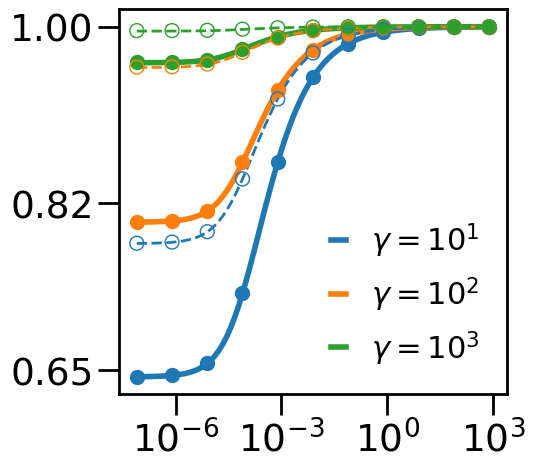

In [8]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
scale = 1.0
labelfont = {'fontsize':20*scale}
tickfont = {'fontsize':27*scale}
legend = {
    'fontsize':22*scale, 'loc':'lower right', 'handlelength':0.5*scale, 
#     'title':'$K_{eq}^S$ ($mM^{-1}$)', 'title_fontsize':20*scale,
#     'title':'$K_{eq}^{PN}$ ($M^{-1}$)', 'title_fontsize':20*scale,
    'framealpha':0.0
}
fig = plt.figure(figsize=(5*scale,5*scale)); ax = fig.add_subplot(111)
plt.tick_params(length=15*scale, width=2*scale)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2*scale)  # change width
C0 = 0.6022 # nm^-3 -> M
colors = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
]
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
linsStyles = ['-', '--']

gamList = np.unique(parm_file['gamma'])
kpnList = np.unique(parm_file['KPN'])
for i, gam in enumerate(gamList):
    for j, kpn in enumerate(kpnList):
        selected = ((parm_file['gamma']==gam)&(parm_file['KPN']==kpn))
        selected_num = ((parm_num['gamma']==gam)&(parm_num['KPN']==kpn))
        if j==0:
            ax.plot(
                (parm_file['KPP']*parm_file['CP0'])[selected],
                (sOcc/(parm_file['CP0']/parm_file['CS0']))[selected],
                label='$\\gamma=10^{%.0f}$'%np.log10(gam),
                color=colors[i], lw=4, ls=linsStyles[j],
                zorder=1
            )
            # numerical solution (true)
            ax.scatter(
                (parm_num['KPP']*parm_num['CP0'])[selected],
                (sOcc_num/(parm_num['CP0']/parm_num['CS0']))[selected_num],
                color=colors[i], zorder=3, s=100,
                marker='o', 
            )
        elif j==1:
            ax.plot(
                (parm_file['KPP']*parm_file['CP0'])[selected],
                (sOcc/(parm_file['CP0']/parm_file['CS0']))[selected],
                color=colors[i], lw=2, ls=linsStyles[j],
                zorder=2,
            )
            # numerical solution (true)
            ax.scatter(
                (parm_num['KPP']*parm_num['CP0'])[selected],
                (sOcc_num/(parm_num['CP0']/parm_num['CS0']))[selected_num],
                color=colors[i], zorder=4, s=100,
                marker='o', facecolor='none',
            )

ax.semilogx()
plt.legend(**legend)
plt.xticks([1e-6, 1e-3, 1e0, 1e3],['$10^{-6}$', '$10^{-3}$', '$10^{0}$', '$10^{3}$'],**tickfont)
plt.yticks([0.65, 0.82, 1],['0.65', '0.82', '1.00'],**tickfont)
plt.show()

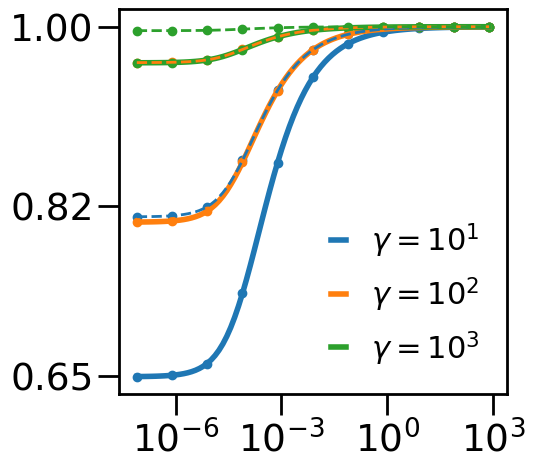

In [62]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
scale = 1.0
labelfont = {'fontsize':20*scale}
tickfont = {'fontsize':27*scale}
legend = {
    'fontsize':22*scale, 'loc':'lower right', 'handlelength':0.5*scale, 
#     'title':'$K_{eq}^S$ ($mM^{-1}$)', 'title_fontsize':20*scale,
#     'title':'$K_{eq}^{PN}$ ($M^{-1}$)', 'title_fontsize':20*scale,
    'framealpha':0.0
}
fig = plt.figure(figsize=(5*scale,5*scale)); ax = fig.add_subplot(111)
plt.tick_params(length=15*scale, width=2*scale)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2*scale)  # change width
C0 = 0.6022 # nm^-3 -> M
colors = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
]
linesStyles = ['-', '--', '-.']
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
varKey = 'gamma'
varList = np.unique(parm_file[varKey])
varKeyMinor = 'KPN'
varListMinor = np.unique(parm_file[varKeyMinor])
for i, var in enumerate(varList):
    for j, varMinor in enumerate(varListMinor):
        selected = ((parm_file[varKey]==var)&(parm_file[varKeyMinor]==varMinor))
        selected_num = ((parm_num[varKey]==var)&(parm_num[varKeyMinor]==varMinor))
        if j==0:
            ax.plot(
                (parm_file['KPP']*parm_file['CP0'])[selected],
                (pBound)[selected],
                label='$\\gamma=10^{%.0f}$'%np.log10(var),
                color=colors[i], lw=4, ls=linesStyles[j],
            )
        elif j==1:
            ax.plot(
                (parm_file['KPP']*parm_file['CP0'])[selected],
                (pBound)[selected],
                color=colors[i], lw=2, ls=linesStyles[j],
                zorder=10,
            )
        # numerical solution (true)
        ax.scatter(
            (parm_num['KPP']*parm_num['CP0'])[selected],
            (pBound_num)[selected_num],
            color=colors[i], 
        )

ax.semilogx()
plt.legend(**legend)
plt.xticks([1e-6, 1e-3, 1e0, 1e3],['$10^{-6}$', '$10^{-3}$', '$10^{0}$', '$10^{3}$'],**tickfont)
plt.yticks([0.65, 0.82, 1],['0.65', '0.82', '1.00'],**tickfont)
plt.show()

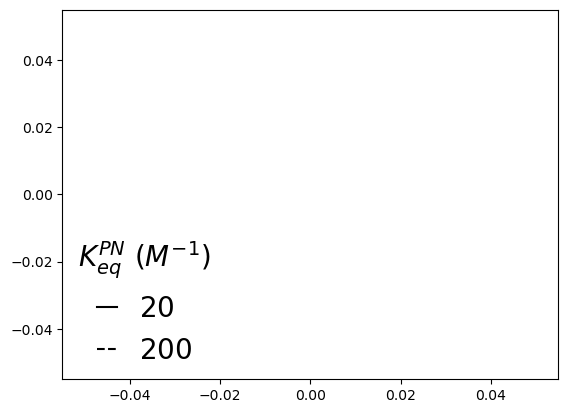

In [65]:
legend = {'fontsize':20*scale, 'loc':[0.01,0.01], 'handlelength':0.7*scale, 
          'title':'$K_{eq}^{PN}$ ($M^{-1}$)', 
          'title_fontsize':20*scale,
         'framealpha':0.0}
lineStyles = ['-', '--']
plt.plot([],[], ls=lineStyles[0], label='$%.0f$'%(kpnList[0]*C0), color='black')
plt.plot([],[], ls=lineStyles[1], label='$%.0f$'%(kpnList[1]*C0), color='black')
plt.legend(**legend)

# read nerdss simulation for searching times

In [12]:
class MONOMER():
    '''
    One monomer found in reactions.
    Store the bound protein and DNA sites
    '''
    def __init__(self, proID:int):
        self.id:int = proID
        self.boundProtein:MONOMER = None
        self.isboundToTarget:bool = False
        self.targetBondTime:float = np.nan
        self.targetBreakTime:float = np.nan
        self.hasBeenBound:bool = False
    
    def updateMonomerBound(self, tNow:float):
        if self.isboundToTarget:
            # -> PS
            if self.targetBondTime is np.nan:
                # P -> PS
                self.targetBondTime = tNow
            else:
                # PS -> PS
                pass
        else:
            # P
            if self.targetBreakTime is np.nan and self.hasBeenBound:
                # P:S -> P
                self.targetBreakTime = tNow
            else:
                # P -> P
                pass
        if not self.hasBeenBound:
            if self.targetBondTime is not np.nan:
                self.hasBeenBound = True
    
    def updateDimerBound(self, tNow:float):
        if self.isboundToTarget:
            # This protein is bound to a target
            if self.targetBondTime is np.nan:
                # This protein was not colocalized with target
                self.targetBondTime = tNow
            else:
                # This protein was colocalized with target
                pass
        else:
            # This protein is not bound to any target
            if self.boundProtein.isboundToTarget:
                # This protein is now colocalized with target
                if self.targetBondTime is np.nan:
                    # This protein was not colocalized with target
                    # PP -> PPS
                    self.targetBondTime = tNow
                else:
                    # This protein was colocalized with target
                    # PSPS -> PPS
                    pass
            else:
                # This dimer is in solution
                if self.targetBreakTime is np.nan and self.hasBeenBound:
                    # PPS -> PP
                    self.targetBreakTime = tNow
                else:
                    # PP -> PP
                    pass
        if not self.hasBeenBound:
            if self.targetBondTime is not np.nan:
                self.hasBeenBound = True
    
    def __str__(self):
        boundInfo = f'isBound: {self.isboundToTarget}\t' + \
                f'boundTime {self.targetBondTime:.3f} s\t' + \
                f'breakTime {self.targetBreakTime:.3f} s'
        if self.boundProtein is not None:
            return f'{self.id:.0f}:{self.boundProtein.id:.0f}\t' + boundInfo
        else:
            return f'{self.id:.0f}:None\t' + boundInfo
    
    def __repr__(self):
        if self.boundProtein is not None:
            return f'{self.id:.0f}:{self.boundProtein.id:.0f}'
        else:
            return f'{self.id:.0f}:None'
        
def getProtein(molID:int, pList:dict[int, MONOMER]):
    if molID in pList:
        protein = pList[molID]
    else:
        protein = MONOMER(molID)
        pList.update({molID:protein})
    return protein

def updateProteinTargetBound(protein:MONOMER, reaction:str, tNow:float):
    if reaction == 'BOND':
        protein.isboundToTarget = True
        if protein.boundProtein is None:
            # This is a monomer
            protein.updateMonomerBound(tNow)
        else:
            # This is a dimer
            protein.updateDimerBound(tNow)
            protein.boundProtein.updateDimerBound(tNow)
    elif reaction == 'BREAK':
        protein.isboundToTarget = False
        if protein.boundProtein is None:
            # This is a monomer
            protein.updateMonomerBound(tNow)
        else:
            # This is a dimer
            protein.updateDimerBound(tNow)
            protein.boundProtein.updateDimerBound(tNow)

def readSearchTime(pdir:str, ifprint=False):
    with open(pdir+'parms.inp') as f:
        for line in f:
            if 'timeStep' in line:
                timeStep = float(line.split('=')[1].split('#')[0])*1e-6
                break

    with open(pdir+'/assoc_dissoc_time.dat') as f:
        searchTimes = []
        resTimes = []
        pList:dict[int,MONOMER] = {}
        for line in f:
            linelist = line.strip().split(',')
            tNow = int(linelist[0].split(':')[1])*timeStep # ITR * timeStep
            mol1 = linelist[2]
            mol1ID = int(linelist[3])
            mol2 = linelist[5]
            mol2ID = int(linelist[6])
            if mol1 == 'N' or mol2 == 'N':
                pass
            else:
                if ifprint: print(linelist)
                if mol1 == 'P' and mol2 == 'P':
                    # reactions between proteins
                    protein1 = getProtein(mol1ID, pList)
                    protein2 = getProtein(mol2ID, pList)
                    if linelist[1] == 'BOND':
                        # two monomers became a dimer
                        protein1.boundProtein = protein2
                        protein2.boundProtein = protein1
                        protein1.updateDimerBound(tNow)
                        protein2.updateDimerBound(tNow)
                    elif linelist[1] == 'BREAK':
                        # one dimer became two monomers
                        protein1.boundProtein = None
                        protein2.boundProtein = None
                        protein1.updateMonomerBound(tNow)
                        protein2.updateMonomerBound(tNow)
                elif mol1 == 'P' and mol2 == 'S':
                    # mol1 = P, mol2 = S
                    protein = getProtein(mol1ID, pList)
                    updateProteinTargetBound(protein, linelist[1], tNow)
                elif mol2 == 'P' and mol1 == 'S':
                    # mol1 = S, mol2 = P
                    protein = getProtein(mol2ID, pList)
                    updateProteinTargetBound(protein, linelist[1], tNow)
                else:
                    # mol1 = S, mol2 = S
                    pass
                
                # update the search time list
                for pID in pList:
                    protein = pList[pID]
                    if ifprint: print(protein)
                    if protein.targetBondTime is not np.nan and protein.targetBreakTime is not np.nan:
                        if protein.targetBondTime > protein.targetBreakTime:
                            # This is a binding event
                            searchTimes.append(
                                protein.targetBondTime - protein.targetBreakTime
                            )
                            protein.targetBreakTime = np.nan
                        else:
                            # This is an unbinding event
                            resTimes.append(
                                protein.targetBreakTime - protein.targetBondTime
                            )
                            protein.targetBondTime = np.nan
                    else:
                        pass
                                
    return np.array(searchTimes), np.array(resTimes)

In [13]:
# sTime, rTime = readSearchTime('../../../Experiments/nerdss_searchTime/kpn1kpp15/')
# len(sTime)

In [14]:
def bootstrapForMean(data, size, n_samples):
    if len(data) == 0:
        return np.nan, np.nan
    else:
        meanvalues = []
        for i in range(n_samples):
            meanvalues.append(np.mean(np.random.choice(data, size=size)))
        return np.mean(meanvalues), np.std(meanvalues)
    
def obtainSearchTimes(KPN_list, KPP_list, jobsdir='../../../Experiments/nerdss_searchTime/'):
    meanSearchT = []
    stdSearchT = []
#     searchTimes = []
    numEvents = []
    for KPN in progressbar(KPN_list):
        kpnMean = []
        kpnStd = []
#         kpnSearchT = []
        kpnNum = []
        for KPP in KPP_list:
            pdir = jobsdir+f'kpn{KPN}kpp{KPP}/'
            sTime, rTime = readSearchTime(pdir)
#             kpnSearchT.append(sTime)
            m, s = bootstrapForMean(sTime, int(len(sTime/10)), 9)
            kpnMean.append(m)
            kpnStd.append(s)
            kpnNum.append(len(sTime))
        meanSearchT.append(kpnMean)
        stdSearchT.append(kpnStd)
#         searchTimes.append(kpnSearchT)
        numEvents.append(kpnNum)
    meanSearchT = np.array(meanSearchT)
    stdSearchT = np.array(stdSearchT)
    
    return np.array(meanSearchT), np.array(stdSearchT), numEvents

logKPN_list = [0, 1, 2, 3, 4, 5]
lnKPP_list = [0, 5, 10, 15, 20]
meanSearchT, stdSearchT, numEvents = obtainSearchTimes(logKPN_list, lnKPP_list)

for l in numEvents:
    print(str(l).replace(', ', ',\t'), '\t', np.sum(l))
print('Total:')
print(str([i for i in np.sum(numEvents,0)]).replace(', ', ',\t'), '\t', np.sum(numEvents))

100% (6 of 6) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01


[209,	218,	212,	132,	153] 	 924
[240,	213,	211,	154,	134] 	 952
[272,	164,	212,	211,	140] 	 999
[138,	185,	204,	163,	170] 	 860
[226,	232,	253,	279,	304] 	 1294
[341,	260,	234,	266,	218] 	 1319
Total:
[1426,	1272,	1326,	1205,	1119] 	 6348


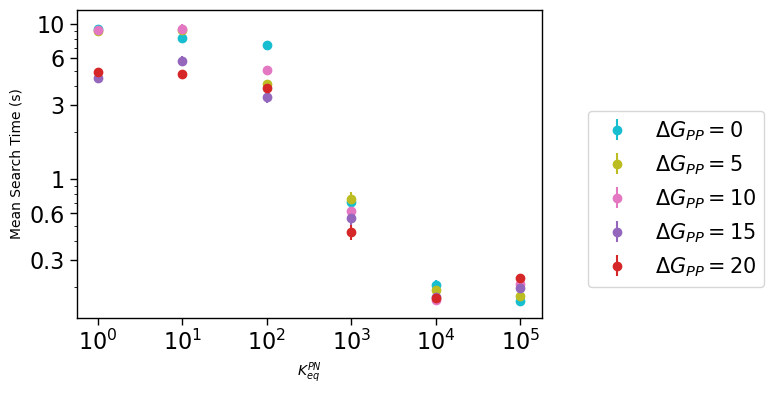

In [17]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
plt.tick_params(length=5,width=1)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1)  # change width
    
colors = plt.cm.tab10_r(np.linspace(0, 1, len(np.arange(0,7,1))))
for i, dGpp in enumerate(lnKPP_list):
    plt.errorbar(
        logKPN_list, meanSearchT[:,i], stdSearchT[:,i], 
        label='$\Delta G_{PP}=%.0f$'%dGpp, ls='', marker='o', 
        color=colors[i]
    )
plt.semilogy()
plt.yticks([0.3, 0.6, 1, 3, 6, 10], [0.3, 0.6, 1, 3, 6, 10])
plt.legend(loc=[1.1,0.1], fontsize=15)
plt.xticks(
    [0, 1, 2, 3, 4, 5], 
    ['$10^0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$'], 
    fontsize=16
)
plt.yticks(fontsize=16)

plt.xlabel('$K_{eq}^{PN}$')
plt.ylabel('Mean Search Time (s)')

plt.show()

# Mass Action Law Results

## Target Occupancy

In [4]:
import sys
import pandas as pd

sys.path.append('..')
# Import analytical results
from DATA.CP62nM import analytical as CP62nM_ana
from DATA.KPP1e8 import analytical as KPP1e8_ana
# Import numerical results
from DATA.CP62nM import numerical as CP62nM
from DATA.KPP1e8 import numerical as KPP1e8

In [5]:
CP62nM_parm = pd.read_csv('../Experiment/CP62nM/parameters.csv')
KPP1e8_parm = pd.read_csv('../Experiment/KPP1e8/parameters.csv')

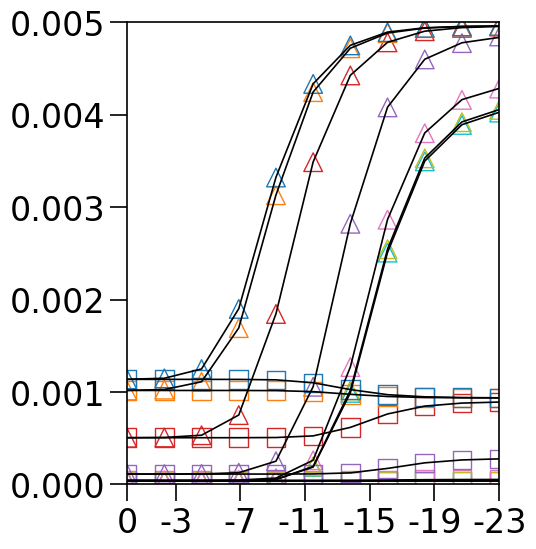

In [10]:
scale = 0.6
labelfont = {'fontsize':20*scale}
tickfont = {'fontsize':40*scale}
legend = {'fontsize':30*scale, 'loc':'best', 'handlelength':1.4*scale, 
          'title':'$\\tau_{mean}^{PN}$ (s)', 'title_fontsize':30*scale}

fig = plt.figure(figsize=(8*scale,10*scale))
ax = fig.add_subplot(111)
plt.tick_params(length=20*scale,width=2*scale)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2*scale)  # change width

parm_file = CP62nM_parm

KPN_list = np.unique(CP62nM_parm['KPN'])
colors = plt.cm.tab10_r(np.linspace(0, 1, len(KPN_list)))

for i, KPNi in enumerate(KPN_list):
    KPN_select = (parm_file['KPN']==KPNi)
    # plot analytical results for model B
    plt.plot(
        np.log(parm_file['KPP'][KPN_select]), 
        np.array(CP62nM_ana.sOcc_singleS)[KPN_select], 
        color='black', ls='-', lw=2*scale,
    )
    ## for model C
    plt.plot(
        np.log(parm_file['KPP'][KPN_select]), 
        np.array(CP62nM_ana.sOcc_doubleS)[KPN_select], 
        color='black', ls='-', lw=2*scale,
    )
    # numerical results for model C
    plt.scatter(
        np.log(parm_file['KPP'][KPN_select]), 
        np.array(CP62nM.sOcc_doubleS)[KPN_select],
        edgecolor=colors[i], facecolor='none',
        marker='^', s=300*scale,
    )
    ## for model B
    plt.scatter(
        np.log(parm_file['KPP'][KPN_select]), 
        np.array(CP62nM.sOcc_singleS)[KPN_select], 
        edgecolor=colors[i], facecolor='none',
        marker='s', s=300*scale,
    )

# plt.semilogy()
plt.xticks(**tickfont)
plt.yticks(**tickfont)

plt.xlim([np.log(1e0), np.log(1e9)])
plt.xticks([23, 19, 15, 11, 7, 3, 0], [-23, -19, -15, -11, -7, -3, 0])
plt.ylim([0,0.005])
# plt.yticks([0, 2e-4, 4e-4, 6e-4, 8e-4, 10e-4], 
#            ['0', '2$\\times10^{-4}$', '4$\\times10^{-4}$', '6$\\times10^{-4}$', '8$\\times10^{-4}$', '1$\\times10^{-3}$'])

plt.show()

## Target Colocalization Time